### Playback walk motion

In [5]:
import time,pickle,mujoco
import numpy as np
import cv2,glob,os
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,MultiSliderClass,create_folder_if_not_exists
import mediapy as media

np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


### Parse

In [6]:
xml_path = '../asset/smpl_rig/scene_smpl_rig.xml'
env = MuJoCoParserClass(name='MyoSuite',rel_xml_path=xml_path,VERBOSE=False)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.9,0.9,0.9,0.5]
print ("Done.")

Done.


In [8]:
for idx, name in enumerate(env.body_names):
    print(idx, name)

0 world
1 base
2 root
3 spine1
4 spine2
5 spine3
6 neck
7 head
8 left_collar
9 left_shoulder
10 left_elbow
11 left_wrist
12 left_index1
13 left_index2
14 left_index3
15 left_index4
16 left_middle1
17 left_middle2
18 left_middle3
19 left_middle4
20 left_ring1
21 left_ring2
22 left_ring3
23 left_ring4
24 left_pinky1
25 left_pinky2
26 left_pinky3
27 left_pinky4
28 left_thumb1
29 left_thumb2
30 left_thumb3
31 left_thumb4
32 right_collar
33 right_shoulder
34 right_elbow
35 right_wrist
36 right_index1
37 right_index2
38 right_index3
39 right_index4
40 right_middle1
41 right_middle2
42 right_middle3
43 right_middle4
44 right_ring1
45 right_ring2
46 right_ring3
47 right_ring4
48 right_pinky1
49 right_pinky2
50 right_pinky3
51 right_pinky4
52 right_thumb1
53 right_thumb2
54 right_thumb3
55 right_thumb4
56 left_pelvis
57 left_knee
58 left_ankle
59 right_pelvis
60 right_knee
61 right_ankle


### Load walking motion

In [3]:
pkl_path = '../data/smplrig_cmu_walk_16_15.pkl'
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)
qs         = data['qpos'] # [L * Nj]
# quat_roots = data['rotation'][:,0,:]
xposes       = data['xpos']
p_roots    = data['root']
height_offset = 0.0
p_roots[:,2] -= height_offset
xposes[:, :, 2] -= height_offset
L = qs.shape[0]
HZ = 10
times = np.linspace(0,HZ/L,L)
print ("[%s] loaded."%(pkl_path))

[../data/smplrig_cmu_walk_16_15_zpos_edited.pkl] loaded.


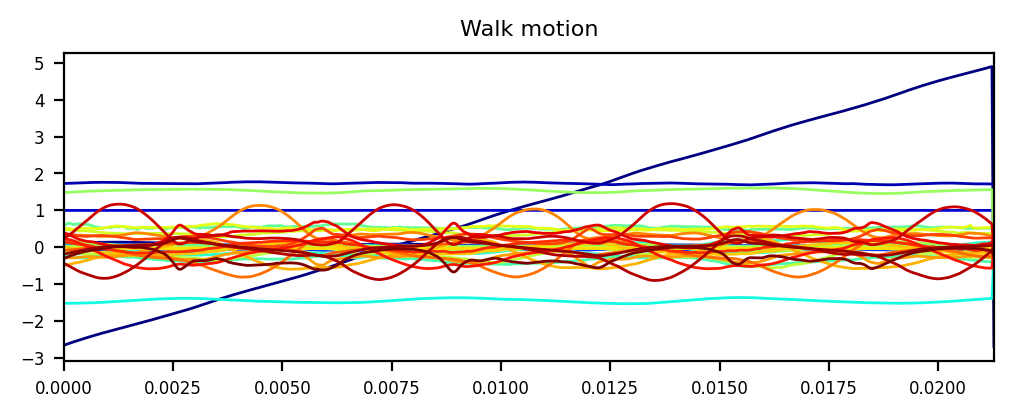

In [4]:
plt.figure(figsize=(6,2))
colors = plt.get_cmap('jet')(np.linspace(0,1,qs.shape[1]))
for i_idx in range(qs.shape[1]):
    plt.plot(times,qs[:,i_idx],'-',lw=1,color=colors[i_idx])
plt.xlim([times[0],times[-1]])
plt.title('Walk motion',fontsize=8)
plt.show()

In [5]:
# Set which joints to control
rev_joint_names = env.rev_joint_names
joint_idxs_fwd = env.get_idxs_fwd(joint_names=rev_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=rev_joint_names)
q_rev_init = env.get_qpos_joints(rev_joint_names)
n_rev_joint = len(rev_joint_names)

In [6]:
# n_rev_joint
np.concatenate((env.rev_joint_mins,env.pri_joint_mins)).shape

(37,)

In [7]:
# Configuration
PLOT_EVERY = 4
SAVE_VID   = False
print ("PLOT_EVERY:[%d] SAVE_VID:[%d]"%(PLOT_EVERY,SAVE_VID))

PLOT_EVERY:[4] SAVE_VID:[0]


### Loop

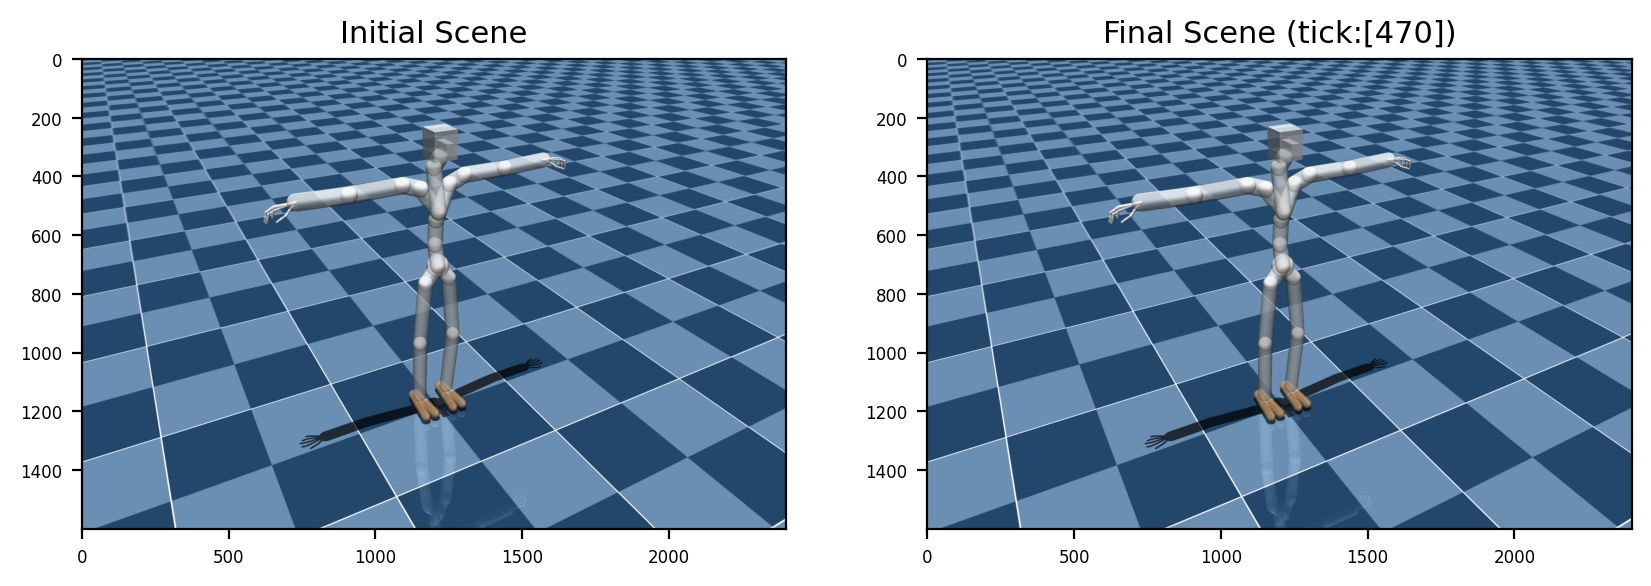

Done.


In [8]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='MyoSuite',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=152,distance=3.0,elevation=-30,lookat=[0.02,-0.03,0.8])
env.reset()
FIRST_FLAG = True
while env.tick < L:

    # Update
    time.sleep(5e-3) # little delay helps
    tick = (env.tick-1) % L
    # contact_in_tick = False

    # FK
    q         = qs[tick,:] # [35]
    p_root    = p_roots[tick,:] # [3]
    quat_root = q[3:7] # [4] quaternion
    env.set_p_root(root_name='base',p=p_root)
    env.set_quat_root(root_name='base',quat=quat_root)
    # env.set_quat_root(root_name='base',quat=)
    env.forward(q=q[joint_idxs_fwd],joint_idxs=joint_idxs_fwd)
    
    # Reset z position of root
    # while not contact_in_tick and len(env.get_contact_info()[0]) == 0:
    while len(env.get_contact_info()[0]) == 0:
        # print(contact_in_tick, len(env.get_contact_info()[0]))
        p_root[2] -= 0.0001
        xposes[tick, :, 2] -= 0.0001
        env.set_p_root(root_name='base',p=p_root)
        env.forward(q=q[joint_idxs_fwd],joint_idxs=joint_idxs_fwd, INCREASE_TICK=False)
        # env.render()
    
    # Update p_roots
    p_roots[tick] = p_root
        
    # Render
    # if env.loop_every(tick_every=1):
    #     # Plot world frame
    #     env.plot_T(p=np.zeros(3),R=np.eye(3,3),
    #                PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
    #     env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
    #                PLOT_AXIS=False,label="tick:[%d]"%(tick))
    #     # Plot foot
    #     # env.plot_geom_T(geom_name='foot2_right',axis_len=0.3)
    #     # env.plot_geom_T(geom_name='foot2_left',axis_len=0.3)
    #     # Plot revolute joints with arrow
    #     env.plot_joint_axis(axis_len=0.1,axis_r=0.01)
    #     env.render()
        
    # Save image
    if env.is_viewer_alive() and FIRST_FLAG:
        scene_img_init = env.grab_image()
        scene_img_final = scene_img_init.copy()
        FIRST_FLAG = False
    # if env.is_viewer_alive() and env.loop_every(tick_every=1000):
    #     scene_img_final = env.grab_image()

    if SAVE_VID:
        # Save iamges
        png_path = '../temp/cmu_smplrig_walk_%05d.png'%(env.tick)
        create_folder_if_not_exists(png_path)
        image = cv2.cvtColor(env.grab_image(),cv2.COLOR_RGB2BGR)
        cv2.imwrite(png_path,image)

    
# Close MuJoCo viewer
env.close_viewer()

# Plot initial and final scenes
fig,axs = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(top=0.85,bottom=0.15,wspace=0.2,hspace=0.5)
axs[0].imshow(scene_img_init)
axs[0].set_title('Initial Scene',fontsize=11)
axs[1].imshow(scene_img_final)
axs[1].set_title('Final Scene (tick:[%d])'%(env.tick),fontsize=11)
plt.show()
print ("Done.")

In [9]:
pkl_data = {
    'length': data['length'],
    'root': p_roots, # Z-position edited
    'qpos': data['qpos'], # Z-position not edited 
    'xpos': xposes
}
with open('../data/smplrig_cmu_walk_16_15_zpos_edited.pkl', 'wb') as f:
    pickle.dump(pkl_data, f)
